In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from functions import *
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [16]:
df = pd.read_csv(r"C:\Users\oe\Desktop\HomeCreditDefaultRisk\data\application_train.csv", nrows=None)
test_df = pd.read_csv(r"C:\Users\oe\Desktop\HomeCreditDefaultRisk\data\application_test.csv", nrows=None)
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()

Train samples: 307511, test samples: 48744


In [17]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [18]:
# DATA PREPROCESSING
df = df[df['CODE_GENDER'] != 'XNA']  # 4 gözlem değeri XNA olarak girilmiş bundan kurtarıldı.
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)  # NaN değerleri 365243 olarak girilmiş, onlar düzeltildi
df["OWN_CAR_AGE"] = df["OWN_CAR_AGE"].fillna(0)  # Araba yaş değeri boş olan gözlemler 0 olarak atandı

# FEATURE ENGINEERING
# AGE gün cinsinden belirtilmiş bu normal yaşa çevrildi.
df["NEW_AGE"] = round(-1 * (df["DAYS_BIRTH"] / 365), 0)
df["NEW_AGE"] = df["NEW_AGE"].astype("int")

# NEW FEATURES
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']  # Müşterinin çalıştığı gün sayısının yaşına oranı
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df[
    'AMT_CREDIT']  # Müşterinin yıllık toplam gelirinin kredi miktarına oranı
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # Kredinin yıllık ödemesinin, kredinin tamamına oranı

# FEATURE 1 - MAAŞ / AİLEDEKİ KİŞİ SAYISI
df['NEW_INC_PERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
# FEATURE 2 - KREDİ MİKTARI / AİLEDEKİ KİŞİ SAYISI
df['NEW_AMT/FAM'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
# FEATURE 3 - KREDİNİN YILLIK ÖDEMESİ / GELİR
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
# FEATURE 4 - GELİR / YILLIK KREDİ * FAMILYSIZE #MODEL SONUCUNA GÖRE DEĞERLENDİR
df["NEW_FAMILY_EFFECT"] = df['NEW_AMT/FAM'] / df['CNT_FAM_MEMBERS']
# # FEATURE 5 - ALMAK İSTEDİĞİ MAL VE ÇEKTİĞİ KREDİ ARASINDAKİ FARKA GÖRE DERECELENDİRME
# df.loc[(df["AMT_CREDIT"] - df["AMT_GOODS_PRICE"] > 0), "NEW_AMT_STATUS"] = 1
# df.loc[(df["AMT_CREDIT"] - df["AMT_GOODS_PRICE"] == 0), "NEW_AMT_STATUS"] = 2
# df.loc[(df["AMT_CREDIT"] - df["AMT_GOODS_PRICE"] < 0), "NEW_AMT_STATUS"] = 3
# FEATURE 6 - ÇEKİLEN KREDİ İLE ÜRÜN ARASINDAKİ FARKIN GELİRE ORANI ***
df["NEW_C-GP"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]
# FEATURE 7 - YAŞ / KREDİ MİKTARI
df["NEW_CREDIT/NEW_AGE"] = df['AMT_CREDIT'] / df["NEW_AGE"]
# FEATURE 8 - ÜRÜN / KREDİ MİKTARI ***
df["NEW_GOODS/CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]
# FEATURE 9 - AGE / OWN_CAR_AGE
df["NEW_AGE/CAR_AGE"] = df["NEW_AGE"] / df["OWN_CAR_AGE"]
# FEATURE 10 - EXT AĞIRLIKLI ÇARPIM
df['NEW_EXT_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
#df["NEW_EXT_X"] = df["EXT_SOURCE_1"] * df["EXT_SOURCE_2"] * df["EXT_SOURCE_3"]
# FEATURE 11 - EXT MEAN
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# FEATURE 12 - EXT STD
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
# FEATURE 13 - NEW EXT PROCESS
df.loc[(df["EXT_SOURCE_1"] >= 0.5) | (df["EXT_SOURCE_2"] >= 0.55) | (df["EXT_SOURCE_3"] >= 0.45), "NEW_BOMB"] = 0
df.loc[(df["EXT_SOURCE_1"] < 0.5) | (df["EXT_SOURCE_2"] < 0.55) | (df["EXT_SOURCE_3"] < 0.45), "NEW_BOMB"] = 1
# FEATURE 14 - DOKUMANLARIN TOPLAMI / DOCS ATILDI
docs = [f for f in df.columns if 'FLAG_DOC' in f]
df['NEW_DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df.drop(docs, axis=1, inplace=True)
# FEATURE 15 - AGE RANK 1: YOUNG 5: OLDER
# df["NEW_AGE_RANK"] = pd.cut(x=df["NEW_AGE"], bins=[0, 27, 40, 50, 65, 99], labels=[1, 2, 3, 4, 5])
# df["NEW_AGE_RANK"] = df["NEW_AGE_RANK"].astype("int")
#df.loc[(df["DAYS_BIRTH"] >= -15000),"NEW_YOUNG_FLAG"] = 1
df.drop("NEW_AGE", axis=1, inplace=True)
# FEATURE 16 NEW_PHONE_TO_BIRTH_RATIO
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
# FEATURE 17 NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER
df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
# FEATURE 18 - NEW_INC_ORG : Sektöründeki maaş ortalamaları
INC_ORG = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
df['NEW_INC_ORG'] = df['ORGANIZATION_TYPE'].map(INC_ORG)
# CLEAN CLASSES & LABEL ENCODING PART

df.loc[(df["OCCUPATION_TYPE"] == "Drivers"), "OCCUPATION_TYPE"] = 1
df.loc[(df["OCCUPATION_TYPE"] == "Waiters/barmen staff"), "OCCUPATION_TYPE"] = 1
df.loc[(df["OCCUPATION_TYPE"] == "Low-skill Laborers"), "OCCUPATION_TYPE"] = 1
df.loc[(df["OCCUPATION_TYPE"] == "Cleaning staff"), "OCCUPATION_TYPE"] = 2
df.loc[(df["OCCUPATION_TYPE"] == "Sales staff"), "OCCUPATION_TYPE"] = 2
df.loc[(df["OCCUPATION_TYPE"] == "Laborers"), "OCCUPATION_TYPE"] = 2
df.loc[(df["OCCUPATION_TYPE"] == "Security staff"), "OCCUPATION_TYPE"] = 2
df.loc[(df["OCCUPATION_TYPE"] == "Cooking staff"), "OCCUPATION_TYPE"] = 2
df.loc[(df["OCCUPATION_TYPE"] == "Medicine staff"), "OCCUPATION_TYPE"] = 3
df.loc[(df["OCCUPATION_TYPE"] == "Private service staff"), "OCCUPATION_TYPE"] = 3
df.loc[(df["OCCUPATION_TYPE"] == "Realty agents"), "OCCUPATION_TYPE"] = 3
df.loc[(df["OCCUPATION_TYPE"] == "Secretaries"), "OCCUPATION_TYPE"] = 3
df.loc[(df["OCCUPATION_TYPE"] == "Accountants"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "Core staff"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "HR staff"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "High skill tech staff"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "Managers"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "Medicine staff"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "Private service staff"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "Realty agents"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "Secretaries"), "OCCUPATION_TYPE"] = 4
df.loc[(df["OCCUPATION_TYPE"] == "IT staff"), "OCCUPATION_TYPE"] = 4

def cols(dataframe, target, noc=10, ID=True):
    """
    noc : number of classes to threshold
    ID : if your data has ID, index etc
    """
    vars_more_classes = []
    if ID:
        ID = dataframe.columns[0]
    else:
        ID = "x"

    cat_cols = [col for col in dataframe.columns if dataframe[col].nunique() < noc
                and col not in target]

    num_cols = [col for col in dataframe.columns if dataframe[col].nunique() > noc
                and dataframe[col].dtypes != "O"
                and col not in target
                and col not in cat_cols and col not in ID]

    other_cols = [col for col in dataframe.columns if col not in cat_cols
                  and col not in num_cols and col not in ID
                  and col not in target]
    return cat_cols, num_cols, other_cols

drop_list = [
    'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
    'LIVE_REGION_NOT_WORK_REGION', 'FLAG_EMAIL', 'FLAG_PHONE',
    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'COMMONAREA_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE', 'ELEVATORS_MEDI', 'EMERGENCYSTATE_MODE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'
]

df.drop(drop_list, axis=1, inplace=True)

cat_cols, num_cols, other_cols = cols(df, "TARGET")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

def rare_analyser(dataframe, target, rare_perc):
    rare_columns = [col for col in dataframe.columns if dataframe[col].dtypes=="O" and len(dataframe[col].value_counts()) <= 20
                    and (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]

    for var in rare_columns:
        print(var, ":", len(dataframe[var].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[var].value_counts(),
                            "RATIO": dataframe[var].value_counts() / len(dataframe),
                            "TARGET_MEDIAN": dataframe.groupby(var)[target].median()}), end="\n\n\n")


df = rare_encoder(df, 0.10)

In [19]:
cat_cols,num_cols,other_cols = cols(df,"TARGET")

CATEGORICAL FEATURE ANALYSIS

NAME_CONTRACT_TYPE : has 2 unique category 	- object

                    NAME_CONTRACT_TYPE   Count      Ratio  TARGET_MEAN
NAME_CONTRACT_TYPE                                                    
Cash loans                      326537  356251  91.659251     0.083459
Rare                             29714  356251   8.340749     0.054791




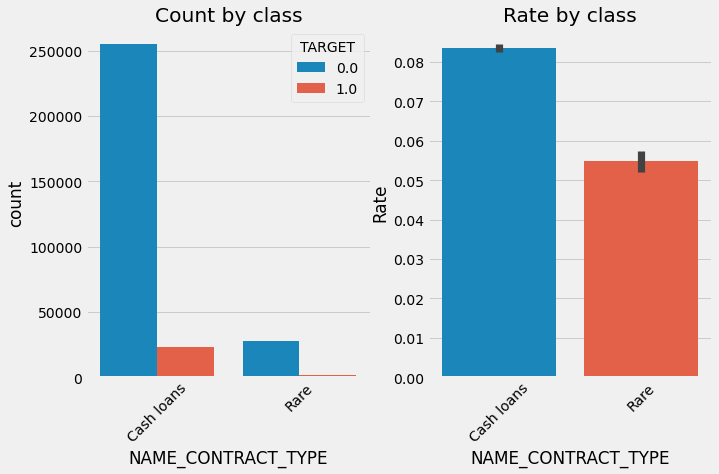




CODE_GENDER : has 2 unique category 	- object

             CODE_GENDER   Count      Ratio  TARGET_MEAN
CODE_GENDER                                             
F                 235126  356251  66.000095     0.069993
M                 121125  356251  33.999905     0.101419




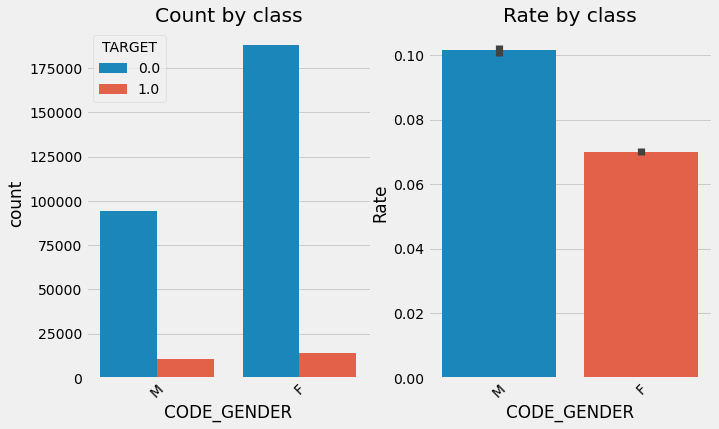




FLAG_OWN_CAR : has 2 unique category 	- object

              FLAG_OWN_CAR   Count     Ratio  TARGET_MEAN
FLAG_OWN_CAR                                             
N                   235233  356251  66.03013     0.085003
Y                   121018  356251  33.96987     0.072439




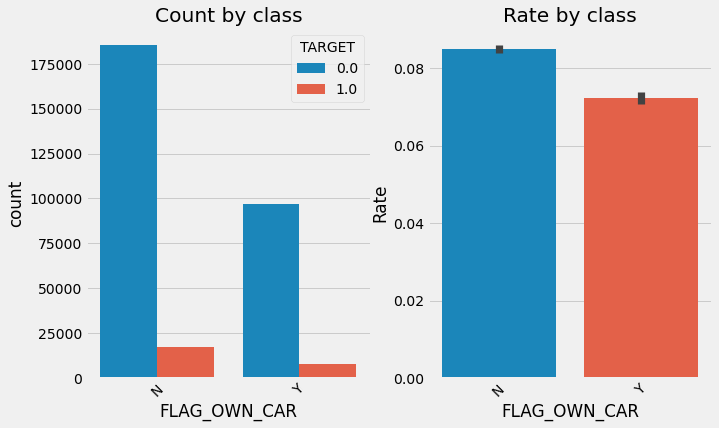




NAME_INCOME_TYPE : has 4 unique category 	- object

                      NAME_INCOME_TYPE   Count      Ratio  TARGET_MEAN
Commercial associate             83018  356251  23.303233     0.074844
Pensioner                        64635  356251  18.143107     0.053864
Rare                             25294  356251   7.100050     0.057864
Working                         183304  356251  51.453610     0.095887




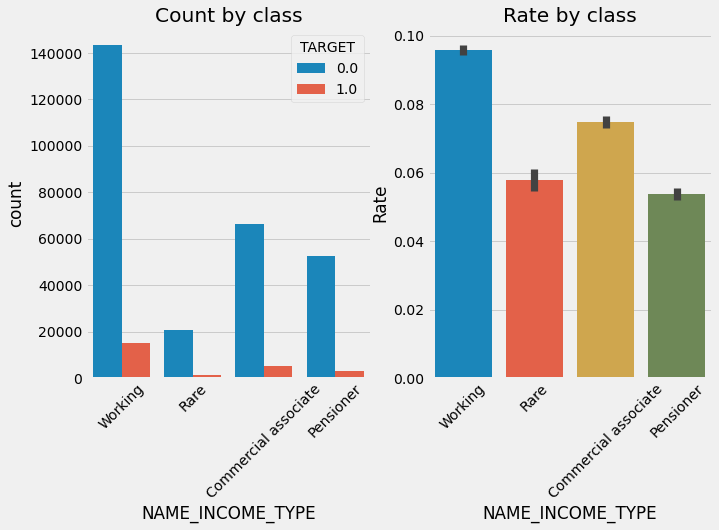




NAME_EDUCATION_TYPE : has 3 unique category 	- object

                               NAME_EDUCATION_TYPE   Count      Ratio  \
Higher education                             87378  356251  24.527089   
Rare                                         16496  356251   4.630443   
Secondary / secondary special               252377  356251  70.842468   

                               TARGET_MEAN  
Higher education                  0.053552  
Rare                              0.090629  
Secondary / secondary special     0.089400  




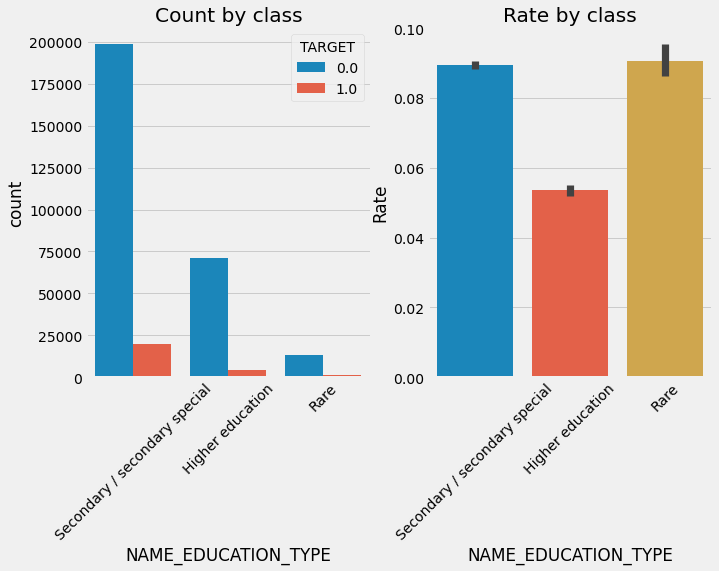




NAME_FAMILY_STATUS : has 3 unique category 	- object

                      NAME_FAMILY_STATUS   Count      Ratio  TARGET_MEAN
NAME_FAMILY_STATUS                                                      
Married                           228712  356251  64.199679     0.075600
Rare                               75059  356251  21.069134     0.084072
Single / not married               52480  356251  14.731187     0.098077




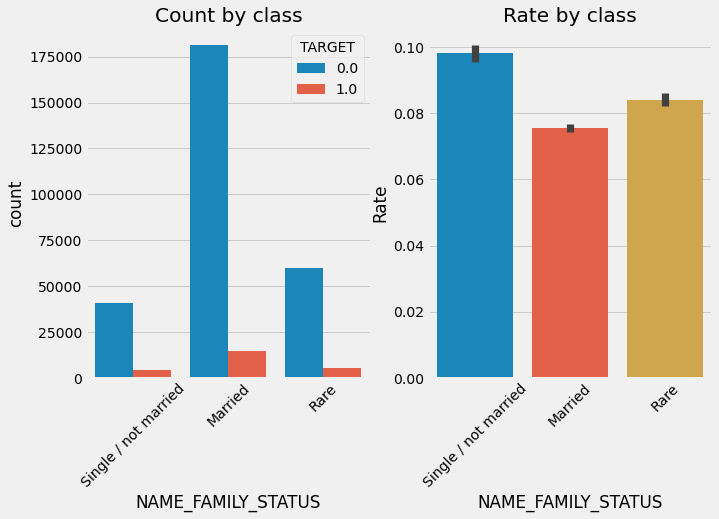




NAME_HOUSING_TYPE : has 2 unique category 	- object

                   NAME_HOUSING_TYPE   Count      Ratio  TARGET_MEAN
NAME_HOUSING_TYPE                                                   
House / apartment             316510  356251  88.844663     0.077958
Rare                           39741  356251  11.155337     0.102563




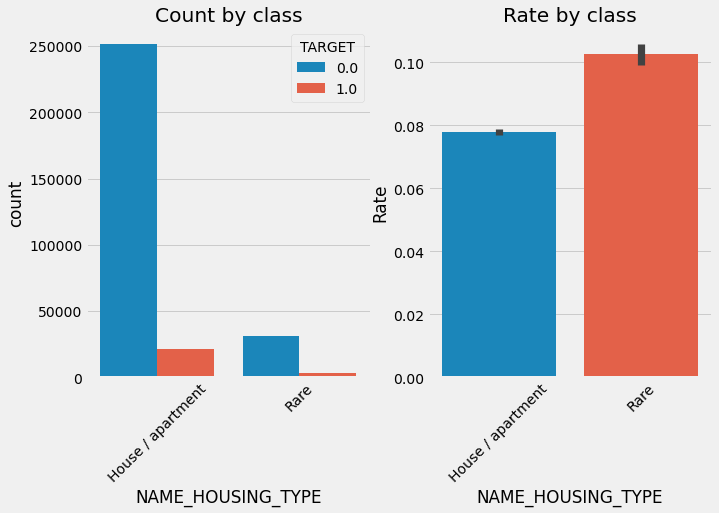




FLAG_WORK_PHONE : has 2 unique category 	- int64

   FLAG_WORK_PHONE   Count      Ratio  TARGET_MEAN
0           284969  356251  79.991074     0.076851
1            71282  356251  20.008926     0.096307




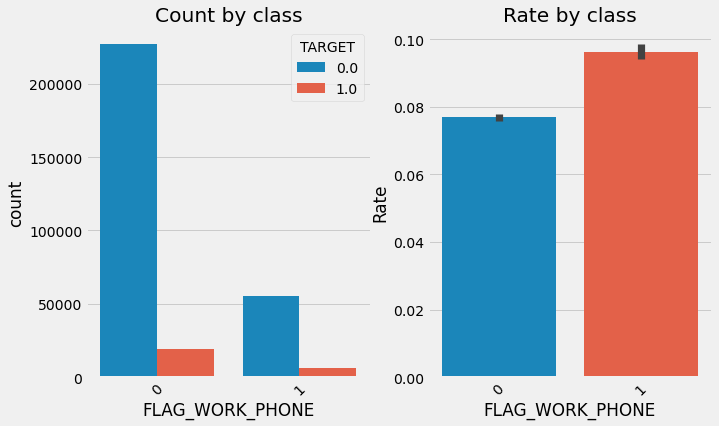




OCCUPATION_TYPE : has 3 unique category 	- object

      OCCUPATION_TYPE   Count      Ratio  TARGET_MEAN
2              120800  356251  33.908677     0.102478
NaN            111994  356251        NaN          NaN
4               82824  356251  23.248777     0.060529
Rare            40633  356251  11.405722     0.099637




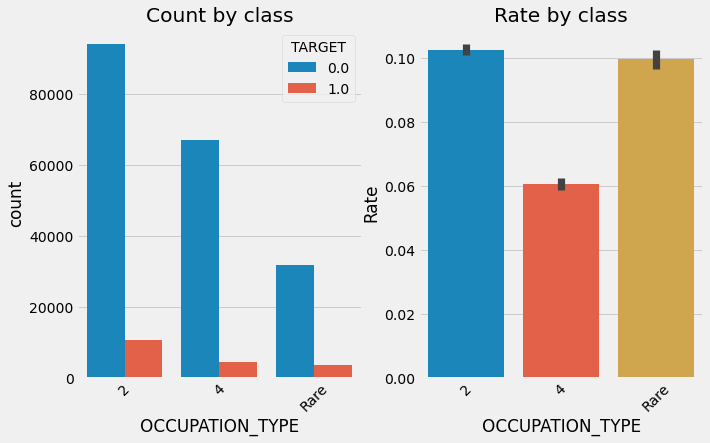




REGION_RATING_CLIENT : has 3 unique category 	- int64

   REGION_RATING_CLIENT   Count      Ratio  TARGET_MEAN
1                 37961  356251  10.655689     0.048203
2                262337  356251  73.638249     0.078892
3                 55953  356251  15.706061     0.111031




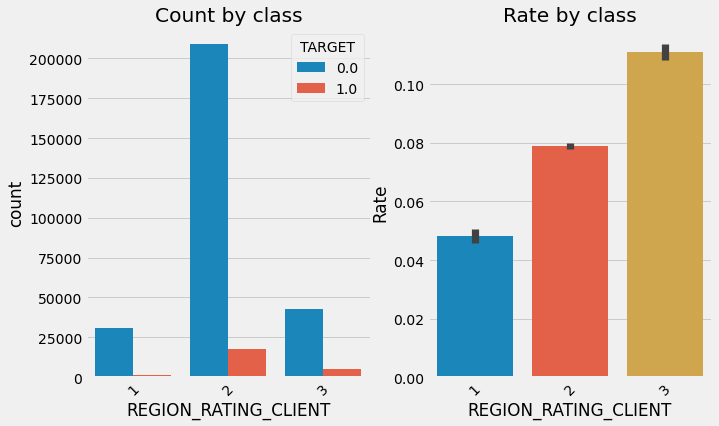




REGION_RATING_CLIENT_W_CITY : has 4 unique category 	- int64

    REGION_RATING_CLIENT_W_CITY   Count      Ratio  TARGET_MEAN
-1                            1  356251   0.000281          NaN
 1                        40342  356251  11.324038     0.048409
 2                       265257  356251  74.457896     0.079179
 3                        50651  356251  14.217785     0.114024




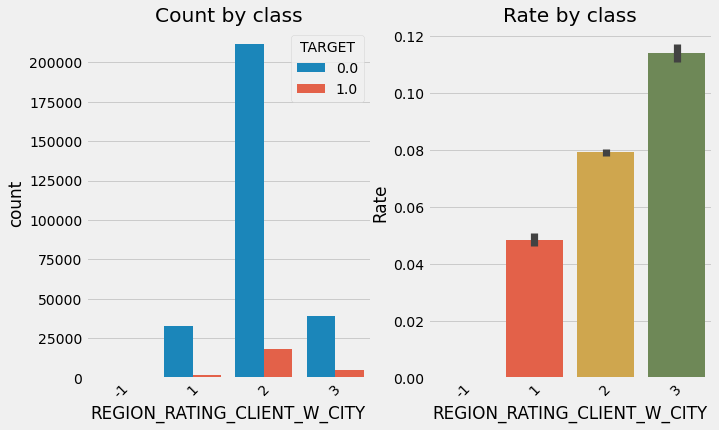




WEEKDAY_APPR_PROCESS_START : has 7 unique category 	- object

           WEEKDAY_APPR_PROCESS_START   Count      Ratio  TARGET_MEAN
FRIDAY                          57586  356251  16.164446     0.081473
MONDAY                          59120  356251  16.595041     0.077572
Rare                            18040  356251   5.063845     0.079291
SATURDAY                        38455  356251  10.794356     0.078873
THURSDAY                        59008  356251  16.563603     0.081004
TUESDAY                         63651  356251  17.866897     0.083506
WEDNESDAY                       60391  356251  16.951812     0.081604




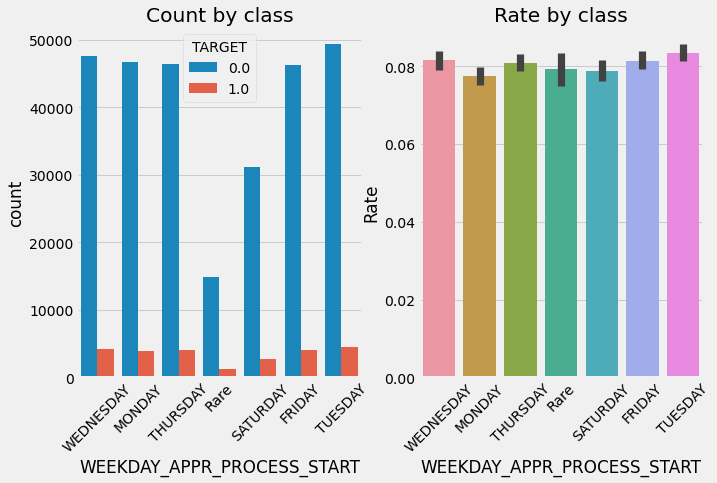




REG_REGION_NOT_LIVE_REGION : has 2 unique category 	- int64

   REG_REGION_NOT_LIVE_REGION   Count      Ratio  TARGET_MEAN
0                      350676  356251  98.435092     0.080542
1                        5575  356251   1.564908     0.092978




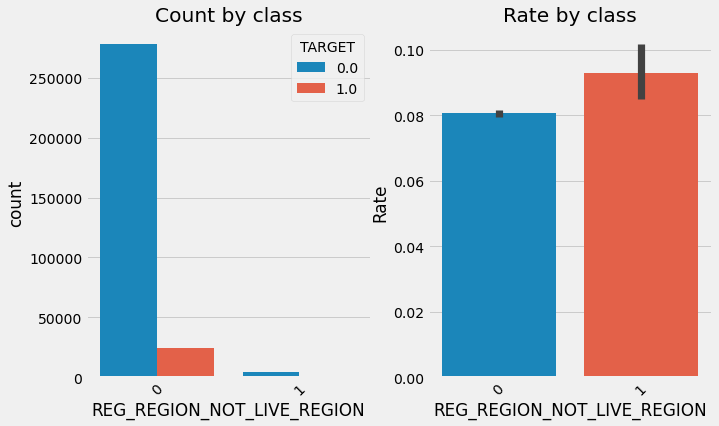




REG_REGION_NOT_WORK_REGION : has 2 unique category 	- int64

   REG_REGION_NOT_WORK_REGION   Count      Ratio  TARGET_MEAN
0                      337950  356251  94.862892     0.080293
1                       18301  356251   5.137108     0.088906




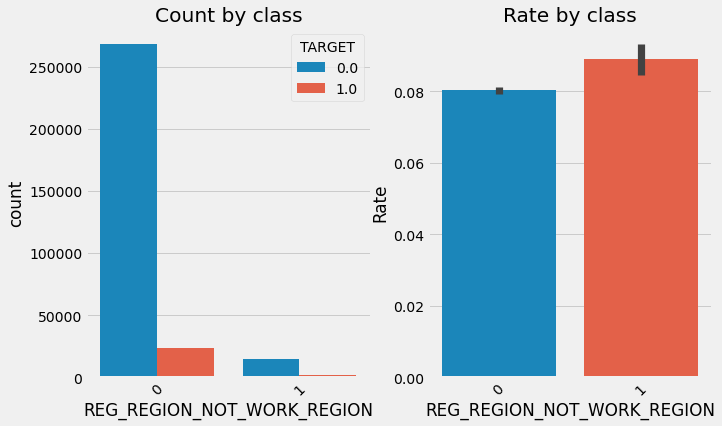




REG_CITY_NOT_LIVE_CITY : has 2 unique category 	- int64

   REG_CITY_NOT_LIVE_CITY   Count      Ratio  TARGET_MEAN
0                  328436  356251  92.192303     0.077208
1                   27815  356251   7.807697     0.122260




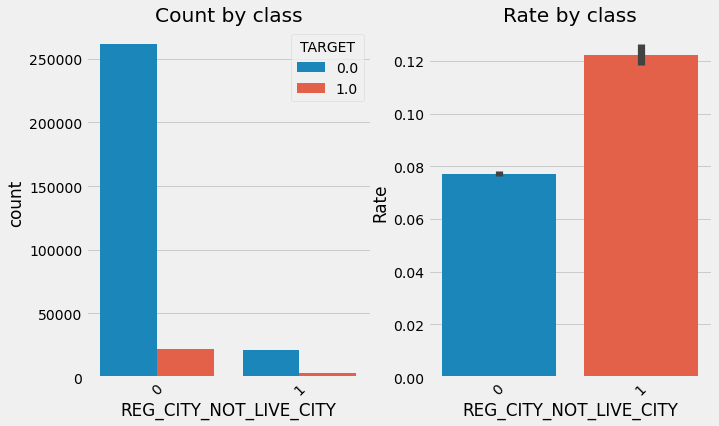




REG_CITY_NOT_WORK_CITY : has 2 unique category 	- int64

   REG_CITY_NOT_WORK_CITY   Count      Ratio  TARGET_MEAN
0                  274433  356251  77.033608     0.073128
1                   81818  356251  22.966392     0.106114




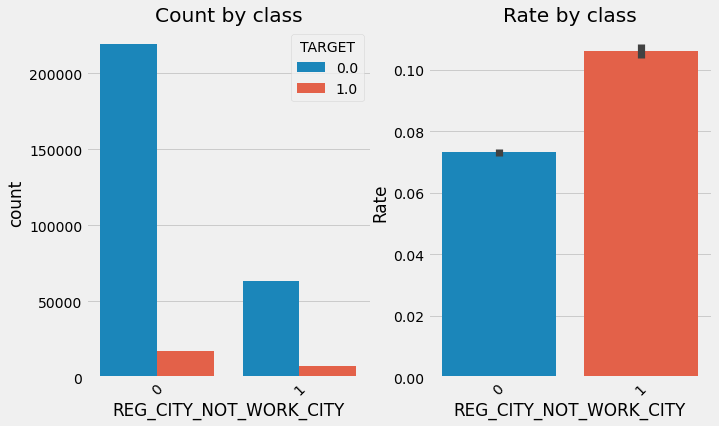




LIVE_CITY_NOT_WORK_CITY : has 2 unique category 	- int64

   LIVE_CITY_NOT_WORK_CITY   Count      Ratio  TARGET_MEAN
0                   292544  356251  82.117384     0.076586
1                    63707  356251  17.882616     0.099665




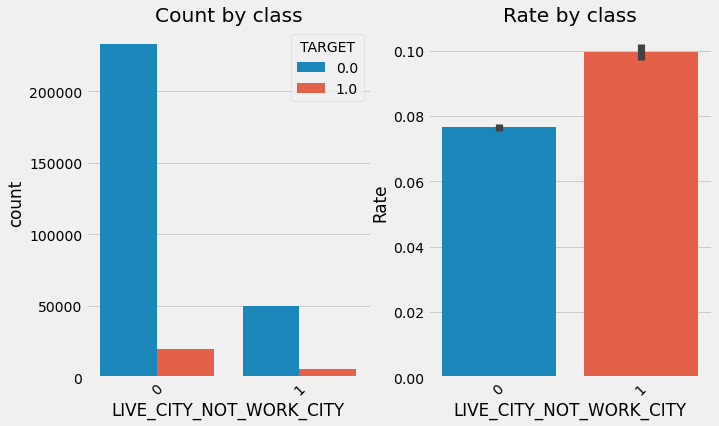




ORGANIZATION_TYPE : has 4 unique category 	- object

                        ORGANIZATION_TYPE   Count      Ratio  TARGET_MEAN
Business Entity Type 3              78832  356251  22.128219     0.092996
Rare                               168439  356251  47.280990     0.079627
Self-employed                       44332  356251  12.444035     0.101739
XNA                                 64648  356251  18.146756     0.053996




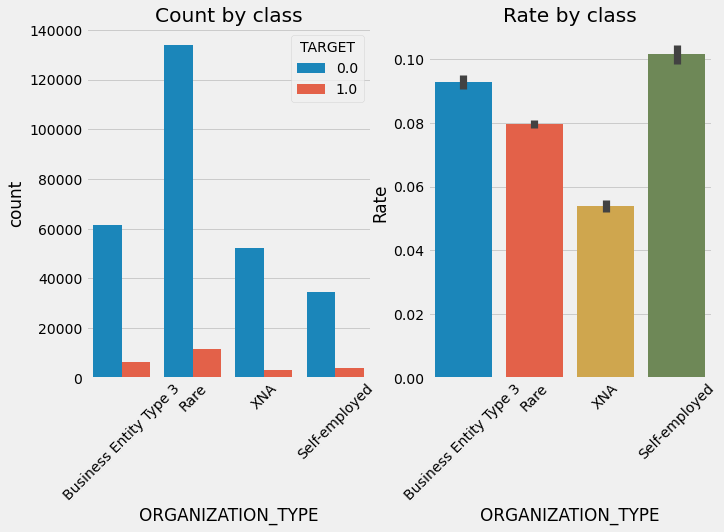




DEF_60_CNT_SOCIAL_CIRCLE : has 9 unique category 	- float64

      DEF_60_CNT_SOCIAL_CIRCLE   Count      Ratio  TARGET_MEAN
0.0                     325333  356251  91.321288     0.078349
1.0                      25324  356251   7.108471     0.105174
2.0                       3666  356251   1.029050     0.121451
3.0                        695  356251   0.195087     0.158863
4.0                        151  356251   0.042386     0.111940
5.0                         24  356251   0.006737     0.150000
6.0                          3  356251   0.000842     0.000000
7.0                          1  356251   0.000281     0.000000
24.0                         4  356251   0.001123     0.000000
NaN                       1050  356251        NaN          NaN




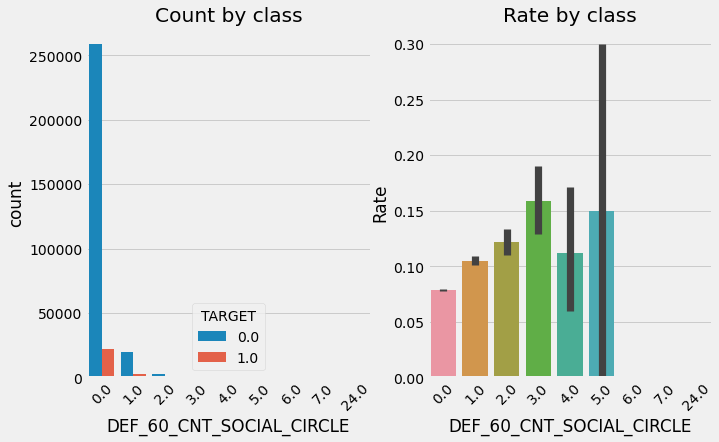




AMT_REQ_CREDIT_BUREAU_DAY : has 9 unique category 	- float64

     AMT_REQ_CREDIT_BUREAU_DAY   Count      Ratio  TARGET_MEAN
0.0                     307124  356251  86.210004     0.077097
1.0                       1355  356251   0.380350     0.096749
2.0                        113  356251   0.031719     0.103774
3.0                         45  356251   0.012632     0.044444
4.0                         26  356251   0.007298     0.115385
5.0                          9  356251   0.002526     0.000000
6.0                          8  356251   0.002246     0.000000
8.0                          1  356251   0.000281     0.000000
9.0                          2  356251   0.000561     0.000000
NaN                      47568  356251        NaN          NaN




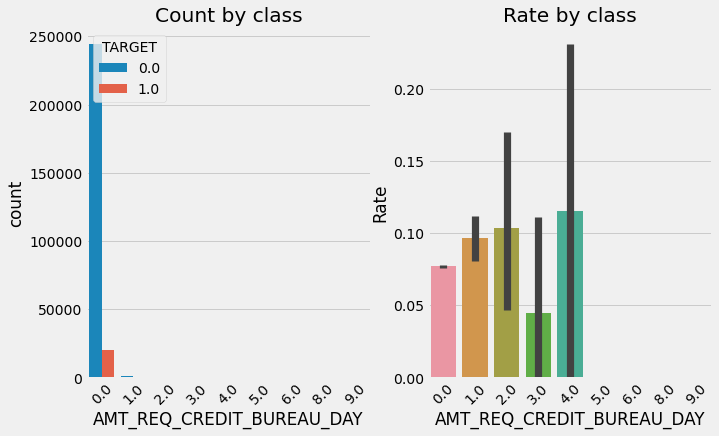




NEW_BOMB : has 2 unique category 	- float64

     NEW_BOMB   Count      Ratio  TARGET_MEAN
0.0    112877  356251  31.684683     0.033270
1.0    243195  356251  68.265072     0.103325
NaN       179  356251        NaN          NaN




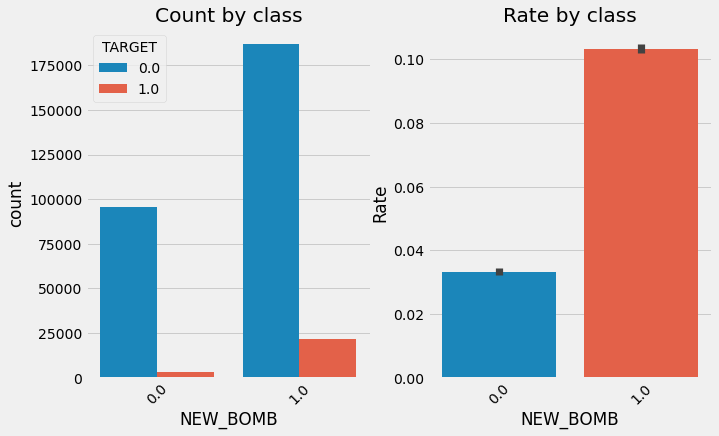




NEW_DOCUMENT_COUNT : has 5 unique category 	- int64

   NEW_DOCUMENT_COUNT   Count      Ratio  TARGET_MEAN
0               30292  356251   8.502994     0.055238
1              318053  356251  89.277784     0.084490
2                7742  356251   2.173187     0.046370
3                 163  356251   0.045754     0.098160
4                   1  356251   0.000281     1.000000




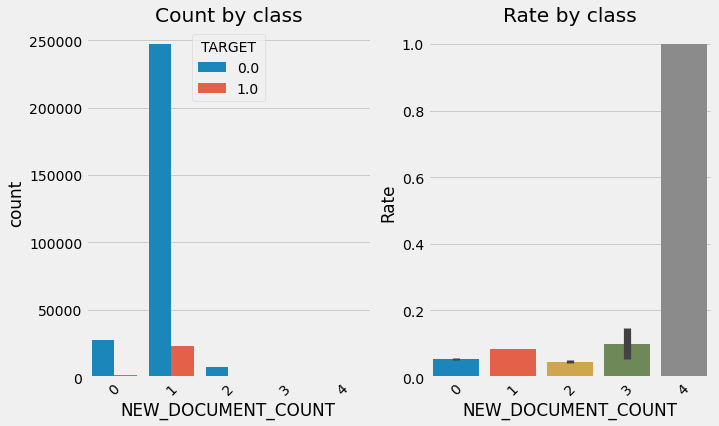




22 categorical variables have been described

There are 0 variables have more than 10 classes

Variable names have more than 10 classes:

[]


In [21]:
cat_summary(df,cat_cols,"TARGET")